<a href="https://colab.research.google.com/github/ackaashg-eng/Disease-Predictor/blob/main/Breast_Cancer_DiseasePredictor_Format.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Detection

**Author:** Automated conversion
**Dataset:** Kaggle — Breast Cancer Prediction (uploaded as `breast-cancer-dataset.csv`)

**Notebook structure (Disease Predictor style)**:
1. Introduction & Problem Statement  
2. Imports & Dependencies  
3. Load & Explore Dataset (EDA + Visualizations)  
4. Data Preprocessing  
5. Model Training (Logistic Regression, Decision Tree, Random Forest)  
6. Model Evaluation (metrics + Confusion Matrix + ROC + Model Comparison)  
7. Conclusion & Next Steps

> This notebook is ready to run in Google Colab. If you uploaded the dataset under a different name, update the file path in the 'Load dataset' cell.


## 1) Imports & Dependencies

Install packages (if running in a fresh Colab) and import required libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, classification_report)

# make plots appear larger by default
plt.rcParams['figure.dpi'] = 120


## 2) Load Dataset

Load the uploaded CSV file. Update the path if needed.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving breast-cancer-dataset.csv to breast-cancer-dataset.csv


In [ ]:
# Load dataset
df = pd.read_csv("breast-cancer-dataset.csv")
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (213, 11)


,S/N,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
0,1,2019,40,1,2,0,Right,0,Upper inner,0,Benign
1,2,2019,39,1,2,0,Left,0,Upper outer,0,Benign
2,3,2019,45,0,4,0,Left,0,Lower outer,0,Benign
3,4,2019,26,1,3,0,Left,0,Lower inner,1,Benign
4,5,2019,21,1,1,0,Right,0,Upper outer,1,Benign


### Quick Data Inspection & Cleaning
- Convert range-like columns (e.g., '1-3') to numeric midpoints.
- One-hot encode categorical fields where appropriate.
- Create a clean target column `target` where 1 = Malignant, 0 = Benign.


In [ ]:
# Quick inspection
display(df.info())
display(df.describe(include='all'))

# Create a working copy
data = df.copy()

# Helper to parse ranges like '1-3' to midpoint
def parse_range(val):
    try:
        s = str(val).strip()
        if '-' in s:
            parts = s.split('-')
            low = float(parts[0])
            high = float(parts[1])
            return (low + high) / 2.0
        # If it is numeric-like, cast to float
        return float(s)
    except:
        return np.nan

# Apply parsing to Tumor Size, Inv-Nodes, Metastasis, and History if present
for col in ['Tumor Size (cm)', 'Inv-Nodes', 'Metastasis', 'History']:
    if col in data.columns:
        data[col] = data[col].apply(parse_range)


# Standardize column names (strip)
data.columns = [c.strip() for c in data.columns]

# Ensure S/N or similar exists; create 'id' column
if 'S/N' in data.columns:
    data.rename(columns={'S/N': 'id'}, inplace=True)
elif 'id' not in data.columns:
    data.insert(0, 'id', range(1, len(data)+1))

# Target encoding: Diagnosis Result -> target (1 malignant, 0 benign)
if 'Diagnosis Result' in data.columns:
    data['target'] = data['Diagnosis Result'].apply(lambda x: 1 if str(x).strip().lower().startswith('mal') else 0)
else:
    # fallback if already encoded
    if 'Diagnosis Result_Malignant' in data.columns:
        data['target'] = data['Diagnosis Result_Malignant']
    else:
        raise ValueError('No diagnosis/result column found.')

# Replace '#' with NaN in 'Breast Quadrant'
if 'Breast Quadrant' in data.columns:
    data['Breast Quadrant'] = data['Breast Quadrant'].replace('#', np.nan)

# Show cleaned preview
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   S/N               213 non-null    int64 
 1   Year              213 non-null    object
 2   Age               213 non-null    int64 
 3   Menopause         213 non-null    int64 
 4   Tumor Size (cm)   213 non-null    object
 5   Inv-Nodes         213 non-null    object
 6   Breast            213 non-null    object
 7   Metastasis        213 non-null    object
 8   Breast Quadrant   213 non-null    object
 9   History           213 non-null    object
 10  Diagnosis Result  213 non-null    object
dtypes: int64(3), object(8)
memory usage: 18.4+ KB


None

,S/N,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
count,213.000000,213,213.000000,213.000000,213,213,213,213,213,213,213
unique,NaN,3,NaN,NaN,13,4,3,3,6,3,2
top,NaN,2020,NaN,NaN,3,0,Left,0,Upper outer,0,Benign
freq,NaN,111,NaN,NaN,34,139,107,139,67,124,120
mean,107.000000,NaN,39.784038,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,61.631972,NaN,14.096712,0.472515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,13.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,54.000000,NaN,30.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,107.000000,NaN,40.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,160.000000,NaN,49.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result,target
0,1,2019,40,1,2.0,0.0,Right,0.0,Upper inner,0.0,Benign,0
1,2,2019,39,1,2.0,0.0,Left,0.0,Upper outer,0.0,Benign,0
2,3,2019,45,0,4.0,0.0,Left,0.0,Lower outer,0.0,Benign,0
3,4,2019,26,1,3.0,0.0,Left,0.0,Lower inner,1.0,Benign,0
4,5,2019,21,1,1.0,0.0,Right,0.0,Upper outer,1.0,Benign,0


## 3) Exploratory Data Analysis (EDA)

We will visualize: age distribution, class balance, tumor size distribution, and quadrant counts (if available).

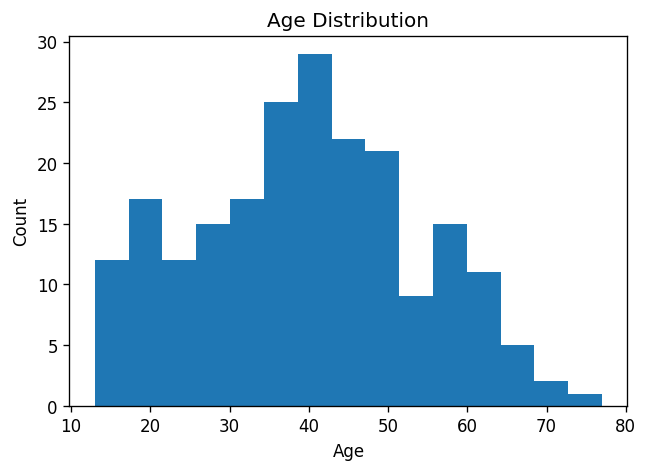

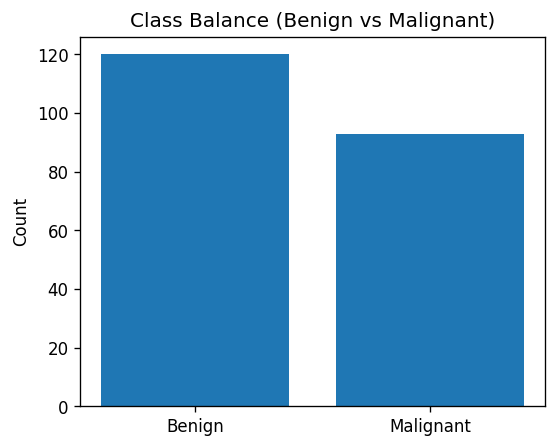

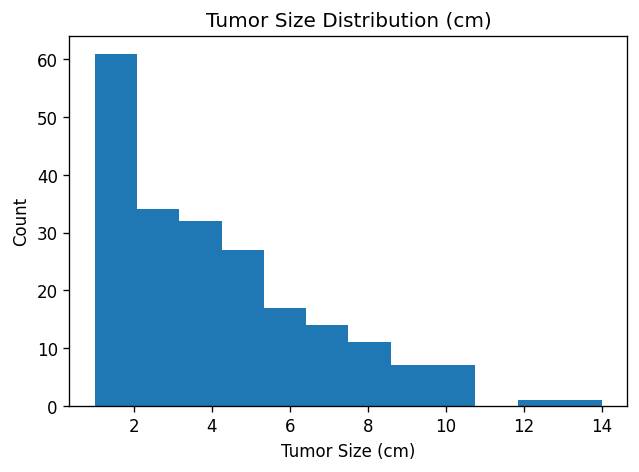

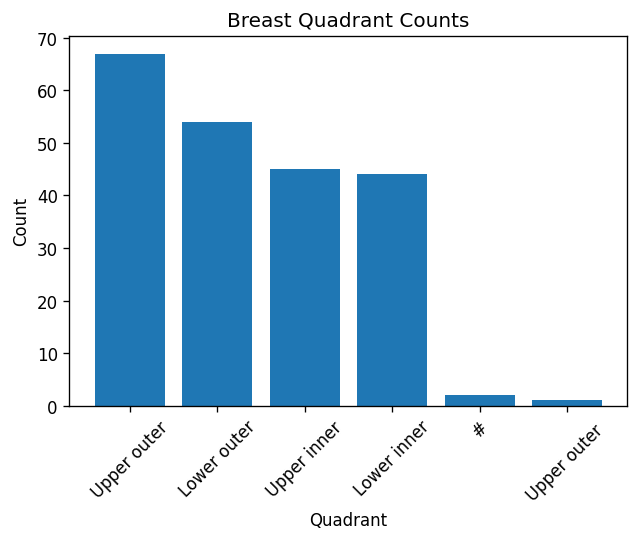

In [ ]:
# Age distribution
if 'Age' in data.columns:
    plt.figure(figsize=(6,4))
    plt.hist(data['Age'].dropna(), bins=15)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

# Class balance (target)
plt.figure(figsize=(5,4))
labels = ['Benign', 'Malignant']
counts = [ (data['target']==0).sum(), (data['target']==1).sum() ]
plt.bar(labels, counts)
plt.title('Class Balance (Benign vs Malignant)')
plt.ylabel('Count')
plt.show()

# Tumor size distribution (if available)
if 'Tumor Size (cm)' in data.columns:
    plt.figure(figsize=(6,4))
    plt.hist(data['Tumor Size (cm)'].dropna(), bins=12)
    plt.title('Tumor Size Distribution (cm)')
    plt.xlabel('Tumor Size (cm)')
    plt.ylabel('Count')
    plt.show()

# Breast quadrant counts (if available)
if 'Breast Quadrant' in df.columns or any(col.startswith('Breast Quadrant') for col in df.columns):
    # if original column exists
    if 'Breast Quadrant' in df.columns:
        quadrant_counts = df['Breast Quadrant'].value_counts()
        plt.figure(figsize=(6,4))
        plt.bar(quadrant_counts.index.astype(str), quadrant_counts.values)
        plt.title('Breast Quadrant Counts')
        plt.xlabel('Quadrant')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
    else:
        # or show dummy columns if one-hot encoded later
        qcols = [c for c in data.columns if 'Breast Quadrant' in c]
        if qcols:
            vals = data[qcols].sum().sort_values(ascending=False)
            plt.figure(figsize=(6,4))
            plt.bar(vals.index, vals.values)
            plt.title('Breast Quadrant (one-hot) Counts')
            plt.xticks(rotation=45)
            plt.show()

## 4) Data Preprocessing

- Fill or drop missing values
- One-hot encode categorical variables (Breast side, Breast Quadrant, Year if needed)
- Scale numeric features
- Split into train/test sets


In [ ]:
# Make a copy for preprocessing
dfp = data.copy()

# Drop columns not needed for modeling (original Diagnosis Result string, Year kept optional)
drop_cols = [c for c in ['Diagnosis Result'] if c in dfp.columns]
dfp.drop(columns=drop_cols, inplace=True, errors='ignore')

# Identify categorical columns to encode
categorical = []
for c in ['Breast', 'Breast Quadrant', 'Year']:
    if c in dfp.columns:
        categorical.append(c)

# One-hot encode categoricals (drop_first to avoid collinearity)
if categorical:
    dfp = pd.get_dummies(dfp, columns=categorical, drop_first=True)

# Convert boolean columns (resulting from one-hot encoding) to integer
for col in dfp.columns:
    if dfp[col].dtype == bool:
        dfp[col] = dfp[col].astype(int)

# Fill numeric NaNs with median
num_cols = dfp.select_dtypes(include=[np.number]).columns.tolist()
# keep 'id' and 'target' as-is
num_cols = [c for c in num_cols if c not in ['id', 'target']]
for c in num_cols:
    dfp[c].fillna(dfp[c].median(), inplace=True)

# Prepare feature matrix X and target y
X = dfp.drop(columns=['id', 'target'])
y = dfp['target']

print('Features shape:', X.shape)
print('Class distribution:', y.value_counts().to_dict())

Features shape: (213, 14)
Class distribution: {0: 120, 1: 93}


/tmp/ipython-input-1107551228.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfp[c].fillna(dfp[c].median(), inplace=True)


### Train-Test Split & Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for convenience (column names preserved)
X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (170, 14) Test shape: (43, 14)


## 5) Model Training

Train Logistic Regression, Decision Tree, and Random Forest classifiers.

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Store predictions and probabilities where applicable
y_proba_lr = log_reg.predict_proba(X_test)[:,1] if hasattr(log_reg, 'predict_proba') else None
y_proba_dt = dt.predict_proba(X_test)[:,1] if hasattr(dt, 'predict_proba') else None
y_proba_rf = rf.predict_proba(X_test)[:,1] if hasattr(rf, 'predict_proba') else None

print('Models trained.')

Models trained.


## 6) Model Evaluation

Compute accuracy, precision, recall, F1, ROC-AUC. Visualize Confusion Matrix and ROC curves.

In [ ]:
# Function to compute metrics
def compute_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc}

metrics = {}
metrics['Logistic Regression'] = compute_metrics(y_test, y_pred_lr, y_proba_lr)
metrics['Decision Tree'] = compute_metrics(y_test, y_pred_dt, y_proba_dt)
metrics['Random Forest'] = compute_metrics(y_test, y_pred_rf, y_proba_rf)

import pprint
pprint.pprint(metrics)

{'Decision Tree': {'accuracy': 0.7674418604651163,
                   'f1': 0.7619047619047619,
                   'precision': 0.6956521739130435,
                   'recall': 0.8421052631578947,
                   'roc_auc': np.float64(0.775219298245614)},
 'Logistic Regression': {'accuracy': 0.9069767441860465,
                         'f1': 0.8823529411764706,
                         'precision': 1.0,
                         'recall': 0.7894736842105263,
                         'roc_auc': np.float64(0.9583333333333333)},
 'Random Forest': {'accuracy': 0.9302325581395349,
                   'f1': 0.9142857142857143,
                   'precision': 1.0,
                   'recall': 0.8421052631578947,
                   'roc_auc': np.float64(0.9473684210526315)}}


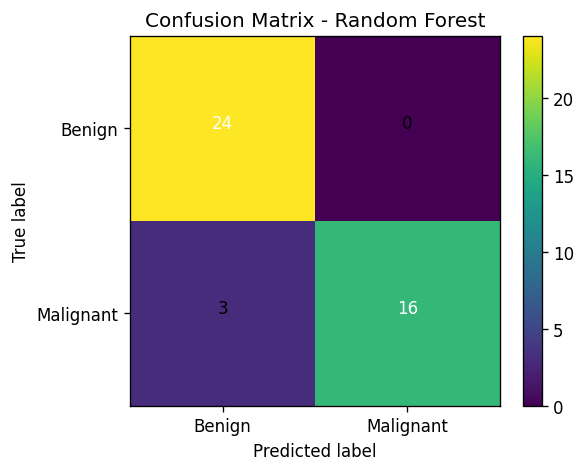

In [ ]:
# Confusion Matrix for Random Forest (as example)
model = rf
y_pred = y_pred_rf

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.title('Confusion Matrix - Random Forest')
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ['Benign','Malignant'])
plt.yticks(ticks, ['Benign','Malignant'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

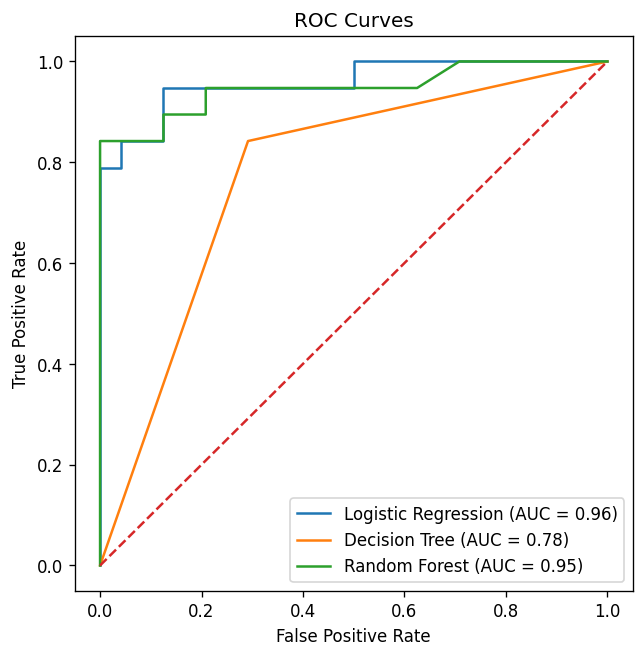

In [ ]:
# ROC Curves (if probabilities available)
plt.figure(figsize=(6,6))
for name, y_proba in [('Logistic Regression', y_proba_lr), ('Decision Tree', y_proba_dt), ('Random Forest', y_proba_rf)]:
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_val = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

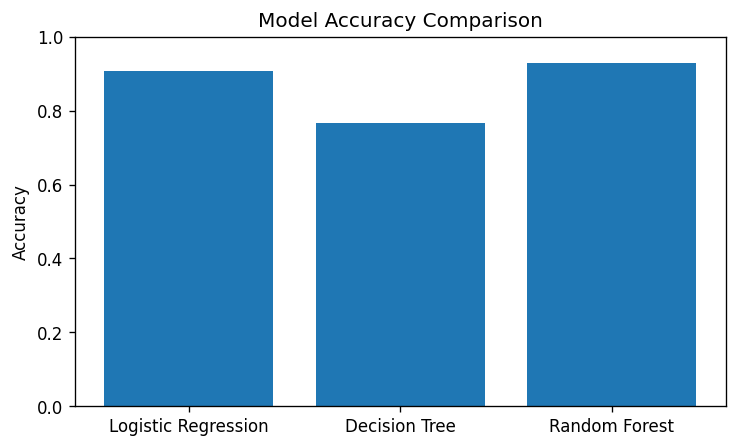

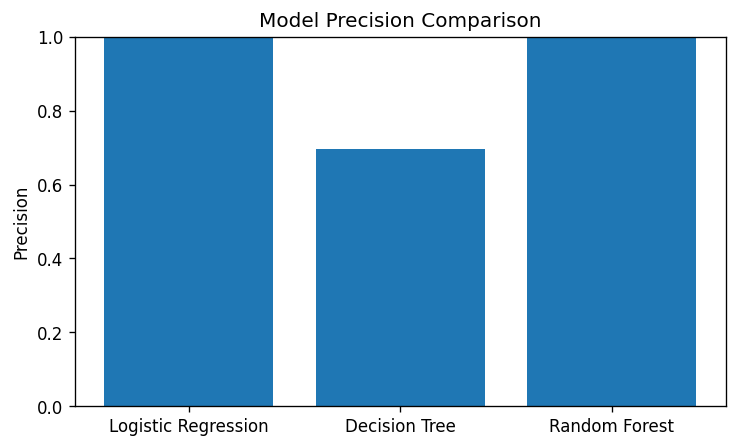

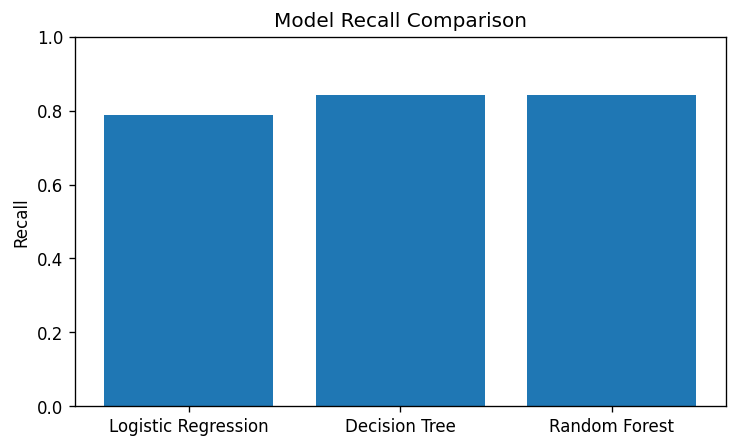

In [ ]:
# Model comparison bar plots for accuracy, precision, recall
names = list(metrics.keys())
accs = [metrics[n]['accuracy'] for n in names]
precs = [metrics[n]['precision'] for n in names]
recs = [metrics[n]['recall'] for n in names]

plt.figure(figsize=(7,4))
plt.bar(names, accs)
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(7,4))
plt.bar(names, precs)
plt.title('Model Precision Comparison')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.show()

plt.figure(figsize=(7,4))
plt.bar(names, recs)
plt.title('Model Recall Comparison')
plt.ylim(0,1)
plt.ylabel('Recall')
plt.show()

## 7) Conclusion & Next Steps

- Summarize results and suggest next steps such as hyperparameter tuning, cross-validation, SMOTE for class imbalance, and model persistence.

In [ ]:
# Identify best model by accuracy (example)
best_name = max(metrics, key=lambda k: metrics[k]['accuracy'])
print('Best model by accuracy:', best_name, metrics[best_name])

# Optionally save the best model
import joblib
best_model = {'Logistic Regression': log_reg, 'Decision Tree': dt, 'Random Forest': rf}[best_name]
# Save to the current directory instead of /mnt/data
joblib.dump(best_model, 'best_breast_cancer_model.pkl')
print('Saved best model to best_breast_cancer_model.pkl')

Best model by accuracy: Random Forest {'accuracy': 0.9302325581395349, 'precision': 1.0, 'recall': 0.8421052631578947, 'f1': 0.9142857142857143, 'roc_auc': np.float64(0.9473684210526315)}
Saved best model to best_breast_cancer_model.pkl
